## 梯度推导

$$ E_k=(T_k-O_k)^2 $$

$$ \frac{\partial E_k}{\partial W_{j,k}}=\frac{\partial E_k}{\partial O_k}\times\frac{\partial O_k}{\partial W_{j,k}} $$

$$ \frac{\partial E_k}{\partial O_k}=\frac{\partial (T_k-O_k)^2}{\partial O_k}=-2(T_k-O_k) $$ 

--- 

$$ O_k = sigmoid(\sum_j W_{j,k}\times O_j) $$

$$ \mu=\sum_j W_{j,k}\times O_j $$

$$ \frac{\partial O_k}{\partial W_{j,k}}=\frac{\partial O_k}{\partial \mu}\times \frac{\partial \mu}{\partial W_{j,k}} $$

$$ \frac{\partial O_k}{\partial \mu} = sigmoid(\mu)\times(1-sigmoid(\mu)) $$
$$ \frac{\partial \mu}{\partial W_{j,k}} = O_j $$ 

--- 
$$ \frac{\partial O_k}{\partial W_{j,k}}=sigmoid(\sum_j W_{j,k}\times O_j) \times (1-sigmoid(\sum_j W_{j,k}\times O_j)) \times O_j $$ 

$$ \frac{\partial E_k}{\partial W_{j,k}}=-2(T_k-O_k)\times sigmoid(\sum_j W_{j,k}\times O_j) \times (1-sigmoid(\sum_j W_{j,k}\times O_j)) \times O_j\\=-2(T_k-O_k)\times O_k \times (1-O_k) \times O_j = -2E_k\times O_k \times (1-O_k) \times O_j $$

## 模型实现

In [310]:
import numpy as np
from scipy.special import expit

class NeuralNetwork:
    """
    初始化函数
        input_size: 输入层神经元个数
        hidden_layers: 一个列表，每层隐层的神经元个数
        output_size：输出层
    """
    def __init__(self, input_size, hidden_layers, output_size, learning_rate = 0.01, output_activation = False):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.output_activation = False
        self.layer_weights = [] 
        
        # 经验A：初始化权重一定要有正有负，否则训练可能无法收敛
        
        # 输入层到第1个隐藏层
        self.layer_weights.append(np.random.random((hidden_layers[0], input_size)) - 0.5)
        # 隐藏层到隐藏层
        for i in range(len(hidden_layers) - 1):
            self.layer_weights.append(np.random.random((hidden_layers[i+1], hidden_layers[i])) - 0.5)
        # 最后的隐层到输出层
        self.layer_weights.append(np.random.random((output_size, hidden_layers[-1])) - 0.5)

    """
    训练函数
        inputs：训练输入
        outputs：训练输出
    """
    def train(self, inputs, outputs):
        # 将矩阵转置，用于后续矩阵运算
        x = np.array(inputs, dtype=np.float).T
        y = np.array(outputs, dtype=np.float).T
        
        """
            前向计算
        """
        layer_outputs = [x]
        for i in range(len(self.layer_weights)):
            x = np.dot(self.layer_weights[i], x)
            if i != len(self.layer_weights) - 1 or self.output_activation: # 非输出层 or 输出层应用激活
                x = expit(x)
            layer_outputs.append(x)

        """
            反向传播误差
        """
        layer_errors = [y-layer_outputs[-1]]
        for i in range(len(self.layer_weights)-1, 0, -1): # 误差只需要传播到第1个隐层即可
            layer_errors.append(np.dot(self.layer_weights[i].T, layer_errors[-1]))
        layer_errors.reverse()
        
        """
            梯度下降（链接权重）
        """
        for i in range(len(self.layer_weights)): 
            if i != len(self.layer_weights)-1 or self.output_activation:
                gradients = np.dot(-2*layer_errors[i]*layer_outputs[i+1]*(1-layer_outputs[i+1]), layer_outputs[i].T)
            else:
                # 经验B：如果输出层没用激活函数，那么这层链接的梯度有差别
                gradients = np.dot(-2*layer_errors[i], layer_outputs[i].T) 
            # 经验C：求出的是一批样本的梯度和，取平均梯度用作更新
            self.layer_weights[i] -= self.learning_rate * (gradients / len(inputs))
    """
    预测函数
        inputs：输入
    """
    def predict(self, inputs):
        x = np.array(inputs, dtype=np.float).T
        for i in range(len(self.layer_weights)):
            x = np.dot(self.layer_weights[i], x)
            if i != len(self.layer_weights) - 1 or self.output_activation: # 非输出层 or 输出层应用激活
                x = expit(x)
        return x.T # 行优先返回

## 模型测试

epoch=1 mse=8.274988
epoch=100001 mse=0.034958
epoch=200001 mse=0.015758
epoch=300001 mse=0.008295
epoch=400001 mse=0.005622
epoch=500001 mse=0.004212
epoch=600001 mse=0.000981
epoch=700001 mse=0.000607
epoch=800001 mse=0.000714
epoch=900001 mse=0.000761


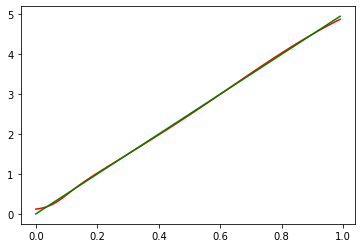

In [316]:
import matplotlib.pyplot as plt 

# 线性函数
def f(x):
    return 5*x

# 生成训练集
train_x = np.arange(0,1,0.01).reshape(-1,1)
train_y = f(train_x)

# 定义神经网络
nn = NeuralNetwork(input_size=1, hidden_layers=[5,4,2], output_size=1, learning_rate=0.001, output_activation=False)

# 训练
for i in range(1000000):
    nn.train(train_x, train_y)

    # 均方误差
    if i % 100000 == 0:
        mse = np.mean(np.power(nn.predict(train_x)-train_y, 2))
        print('epoch=%d mse=%f' % (i+1, mse))

# 绘制图像
plt.plot(train_x, nn.predict(train_x), c='red')
plt.plot(train_x, train_y, c='green')